#  Recurrent Neural Network Excercise

In this exercise, you will learn how to build RNN and LSTM models to classify images of handwritten digits from MNIST dataset. 

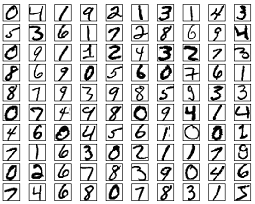

The MNIST dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. More information on the MNIST dataset can be found at: http://yann.lecun.com/exdb/mnist/

To classify images using a recurrent neural network, each image (shape 28*28 pixels) is divided into 28 rows and sent into the network row by row, i.e., when t=1, row 1 is sent into the network, and so on, when t=28, the last row is sent into the network, as shown in the figure below.


 <!-- we consider every image row as a sequence of pixels. Because MNIST image shape is 28*28 pixels, we will then handle 28 sequences of 28 pixels for every MNIST image, as shown in the figure below. -->

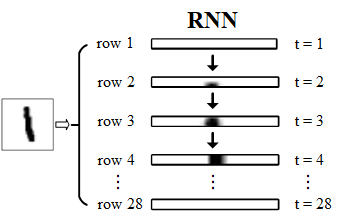

This exercise includes **3 parts**.


# Excercise Part 1: Basic RNN

In Excercise Part 1, perform the following steps.

1.1: Run the provided setup code.

1.2: Complete the code in 1.2 used to build basic RNN models and run. **The code in 1.2 will be graded**.

1.3: Run the provided code to configure the 1st basic RNN model. The size of its hidden states is set to 128.

1.4: Run the provided code to train the 1st basic RNN model. 

1.5: Run the provided code to test the trained 1st basic RNN model. 

1.6: Complete and run the code to configure the 2nd basic RNN model. You need to set the size of its hidden states to 64. **The code in 1.6 will be graded**.

1.7: Run the provided code to train the 2nd basic RNN model. 

1.8: Run the provided code to test the trained 2nd basic RNN model. 

1.9: Answer questions in 1.9.1, 1.9.2, and 1.9.3. **The answers in 1.9.1, 1.9.2, and 1.9.3 will be graded**.


STEP 1.1: SETUP CODE FOR EXCERCISE PART 1

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import os
import numpy as np
import random
from matplotlib import pyplot as plt

# Define training parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128

# Define network parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 # timesteps
num_classes = 10 # MNIST total classes (0-9 digits)

# Import MNIST dataset from tensorflow_dataset (tfds). 
# More information about tfds can be found on https://www.tensorflow.org/datasets/api_docs/python/tfds
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False, # True
    as_supervised=True,
    with_info=True,
)

# Function to transform train and test datasets
def transform(image, label):
  """Transform images: remove last dimension of size 1"""
  """Transform images: uint8 -> float32"""
  """Transform labels: indices -> one-hots"""
  return tf.cast(tf.squeeze(image, -1), tf.float32) / 255., tf.one_hot(label, 10)

# Pre-process train dataset
ds_train = ds_train.map(
    transform, num_parallel_calls=tf.data.AUTOTUNE) 
ds_train = ds_train.cache() # 
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# Pre-process test dataset
ds_test = ds_test.map(
    transform, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


STEP 1.2: COMPLETE CODE USED TO BUILD BASIC RNN MODELS

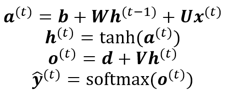

Fig. 1: Formulas for a basic RNN model

In [3]:
class RNN(keras.layers.Layer):
  def __init__(self, input_dim, hidden_dim, output_dim, batch_sz):
    super(RNN, self).__init__()
    init = tf.random_normal_initializer()

    self.b = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,1), dtype="float32"),
        trainable=True)

    self.W = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,hidden_dim), dtype="float32"),
        trainable=True)
    
    self.d = tf.Variable(
        initial_value=init(shape=(1,output_dim,1), dtype="float32"),
        trainable=True)

    self.V = tf.Variable(
        initial_value=init(shape=(1,output_dim,hidden_dim), dtype="float32"),
        trainable=True)
    
    ################################################################################
    # TODO:                                                                        #
    # b, W, U, d, and V are model parameters.                                      #
    # The code to initialize b, W, d, and V is provided above.                     # 
    # Please fill in the space indicated by ***** to initialize U as well.         #
    # Hint: You can infer the shape of U from the 1st equation in Fig. 1.          # 
    ################################################################################
    self.U = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,input_dim), dtype="float32"),
        trainable=True)
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    
  def call(self, x, h_init, num_timestep):
    # Inputs:                                                                      
    # x: [batch_sz,num_row,num_column]                                           
    # h_init: [1,num_hidden,1]                                                                                                       
    # num_timestep: int                                                          
    # Output:                                                                      
    # y: [batch_sz,num_class], softmax normalized class probabilities 

    h = h_init
    for ts in range(num_timestep):
      # curr_x: input sequence at the current timestep
      curr_x = tf.expand_dims(x[:,ts,:], -1) # [b,input_dim,1]
      a = self.b + tf.linalg.matmul(self.W, h) + tf.linalg.matmul(self.U, curr_x) 
      ################################################################################
      # TODO:                                                                        #
      # Fill in the space indicated by ***** to implement the 2nd equation in Fig. 1 #
      # to compute hidden state h from activation a.                                 #
      # You should use tf.math.tanh. More information on tf.math.tanh can be found   #
      # at https://www.tensorflow.org/api_docs/python/tf/math/tanh                   #
      ################################################################################
      h = tf.math.tanh(a)
      ################################################################################
      #                              END OF YOUR CODE                                #
      ################################################################################

    y = self.d + tf.linalg.matmul(self.V, h)
    y =  tf.squeeze(y)
    y = tf.nn.softmax(y, axis=-1)

    return y

STEP 1.3: CONFIGURE THE 1ST BASIC RNN MODEL

Use the provided code to configure the 1st basic RNN model whose hidden states have the size of 128.

In [4]:
# Configure the 1st basic RNN model
basic_RNN1 = RNN(input_dim=num_input, 
    hidden_dim=128, 
    output_dim=num_classes, 
    batch_sz=batch_size)

# Instantiate a tf.keras.Model for the 1st basic RNN model
# More information can be found at https://www.tensorflow.org/api_docs/python/tf/keras/Model
input_data = tf.keras.Input(shape=(timesteps, num_input), batch_size=batch_size, 
    dtype=tf.float32)
h_init = 0 * tf.ones([1,128,1], tf.float32)
prediction_basic_RNN1 = basic_RNN1(input_data, h_init=h_init, num_timestep=timesteps)

model_basic_RNN1 = tf.keras.Model(input_data, prediction_basic_RNN1)
model_basic_RNN1.compile(optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

STEP 1.4: TRAIN THE 1ST BASIC RNN MODEL

You should expect to see training accuracy > or near 90%.

In [5]:
with tf.device('/GPU:0'):
  model_basic_RNN1.fit(ds_train, epochs=4)

Epoch 1/4
468/468 [==============================] - 30s 14ms/step - loss: 0.8682 - accuracy: 0.7116
Epoch 2/4
468/468 [==============================] - 4s 8ms/step - loss: 0.4889 - accuracy: 0.8527
Epoch 3/4
468/468 [==============================] - 4s 8ms/step - loss: 0.3528 - accuracy: 0.8991
Epoch 4/4
468/468 [==============================] - 4s 8ms/step - loss: 0.2717 - accuracy: 0.9227


STEP 1.5: TEST THE TRAINED 1ST BASIC RNN MODEL

You should expect to see testing accuracy > or near 90%.

In [6]:
# Test the trained 1st basic RNN model 
h_init = 0 * tf.ones([1,128,1], tf.float32)

predicted_digits = []
gt_digits = []
for input_sequences, gt_digit in ds_test:
  predicted_digit = basic_RNN1(input_sequences, h_init=h_init, num_timestep=timesteps)
  
  # one-hot to index
  predicted_digits.append(np.squeeze(tf.argmax(predicted_digit, axis=-1).numpy()))
  gt_digits.append(np.squeeze(tf.argmax(gt_digit, axis=-1).numpy()))

predicted_digits = np.squeeze(np.concatenate(predicted_digits))
gt_digits = np.squeeze(np.concatenate(gt_digits))

test_accuracy = np.sum(predicted_digits == gt_digits) / np.shape(predicted_digits)[0]

print('Testing accuracy of the 1st basic RNN model: %f' % test_accuracy)

Testing accuracy of the 1st basic RNN model: 0.935900


STEP 1.6: CONFIGURE THE 2ND BASIC RNN MODEL

Complete the code to configure the 2nd basic RNN model whose hidden states have the size of 64.

In [7]:
# Configure the 2nd basic RNN model
################################################################################
# TODO:                                                                        #
# Fill in the space indicated by ***** to configure a basic RNN model where    #
# the size of hidden states is 64..                                            #
################################################################################
basic_RNN2 = RNN(input_dim=num_input, 
      hidden_dim=64, 
      output_dim=num_classes, 
      batch_sz=batch_size)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Instantiate a tf.keras.Model for the 2nd basic RNN model
# More information can be found at https://www.tensorflow.org/api_docs/python/tf/keras/Model
input_data = tf.keras.Input(shape=(timesteps, num_input), batch_size=batch_size, 
    dtype=tf.float32)
h_init = 0 * tf.ones([1,64,1], tf.float32)
prediction_basic_RNN2 = basic_RNN2(input_data, h_init=h_init, num_timestep=timesteps)

model_basic_RNN2 = tf.keras.Model(input_data, prediction_basic_RNN2)
model_basic_RNN2.compile(optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

STEP 1.7: TRAIN THE 2ND BASIC RNN MODEL

In [8]:
with tf.device('/GPU:0'):
  model_basic_RNN2.fit(ds_train, epochs=4)

Epoch 1/4
468/468 [==============================] - 12s 14ms/step - loss: 1.7017 - accuracy: 0.3756
Epoch 2/4
468/468 [==============================] - 6s 13ms/step - loss: 1.1695 - accuracy: 0.5927
Epoch 3/4
468/468 [==============================] - 4s 8ms/step - loss: 0.8721 - accuracy: 0.7092
Epoch 4/4
468/468 [==============================] - 4s 8ms/step - loss: 0.7220 - accuracy: 0.7583


STEP 1.8: TEST THE TRAINED 2ND BASIC RNN MODEL

In [9]:
# Test the trained 2nd basic RNN model 
h_init = 0 * tf.ones([1,64,1], tf.float32)

predicted_digits = []
gt_digits = []
for input_sequences, gt_digit in ds_test:
  predicted_digit = basic_RNN2(input_sequences, h_init=h_init, num_timestep=timesteps)
  
  # one-hot to index
  predicted_digits.append(np.squeeze(tf.argmax(predicted_digit, axis=-1).numpy()))
  gt_digits.append(np.squeeze(tf.argmax(gt_digit, axis=-1).numpy()))

predicted_digits = np.squeeze(np.concatenate(predicted_digits))
gt_digits = np.squeeze(np.concatenate(gt_digits))

test_accuracy = np.sum(predicted_digits == gt_digits) / np.shape(predicted_digits)[0]

print('Testing accuracy of the 2nd basic RNN model: %f' % test_accuracy)

Testing accuracy of the 2nd basic RNN model: 0.780000


STEP 1.9: ANSWER THE QUESTIONS BELOW

1.9.1: During trainig, we set initial hidden state (h_init) to all zeros for both models. During testing, we also set initial hidden state (h_init) to all zeros for both models. If we set h_init to all 1000s during testing, can we get similar accuracies as before? Complete and run the code below to find out. 

Report testing accuracies with h_init set to all zeros and all 1000s and give a possible explanation for the accuracy difference.

In addition, can you think of two different ways to set initial hidden state during training and testing? 

In [10]:
# Test the trained basic RNN models with h_init set to all 1000s
################################################################################
# TODO:                                                                        #
# Fill in the space indicated by ***** to set h_init_RNN1 and h_init_RNN2 to   #
# all 1000s.                                                                   #
################################################################################
h_init_RNN1 = 1000 * tf.ones([1,128,1], tf.float32)
h_init_RNN2 = 1000 * tf.ones([1,64,1], tf.float32)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

predicted_digits_RNN1 = []
predicted_digits_RNN2 = []
gt_digits = []
for input_sequences, gt_digit in ds_test:
  predicted_digit_RNN1 = basic_RNN1(input_sequences, h_init=h_init_RNN1, num_timestep=timesteps)
  predicted_digit_RNN2 = basic_RNN2(input_sequences, h_init=h_init_RNN2, num_timestep=timesteps)

  # one-hot to index
  predicted_digits_RNN1.append(np.squeeze(tf.argmax(predicted_digit_RNN1, axis=-1).numpy()))
  predicted_digits_RNN2.append(np.squeeze(tf.argmax(predicted_digit_RNN2, axis=-1).numpy()))

  gt_digits.append(np.squeeze(tf.argmax(gt_digit, axis=-1).numpy()))

predicted_digits_RNN1 = np.squeeze(np.concatenate(predicted_digits_RNN1))
predicted_digits_RNN2 = np.squeeze(np.concatenate(predicted_digits_RNN2))
gt_digits = np.squeeze(np.concatenate(gt_digits))

test_accuracy_RNN1 = np.sum(predicted_digits_RNN1 == gt_digits) / np.shape(predicted_digits_RNN1)[0]
test_accuracy_RNN2 = np.sum(predicted_digits_RNN2 == gt_digits) / np.shape(predicted_digits_RNN2)[0]

print('Testing accuracy of the 1st basic RNN model with h_init set to all 1000s: %f' % test_accuracy_RNN1)
print('Testing accuracy of the 2nd basic RNN model with h_init set to all 1000s: %f' % test_accuracy_RNN2)

Testing accuracy of the 1st basic RNN model with h_init set to all 1000s: 0.284300
Testing accuracy of the 2nd basic RNN model with h_init set to all 1000s: 0.734000


Your Answer: *fill this in.*

1.9.2: Run the code below to print summaries of the 2 basic RNN models. Based on printed summaries, how many trainable parameters are there? Which model has more trainable parameters and why?

More details can be found at https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [11]:
model_basic_RNN1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 28, 28)]           0         
                                                                 
 rnn (RNN)                   (128, 10)                 21386     
                                                                 
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_basic_RNN2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(128, 28, 28)]           0         
                                                                 
 rnn_1 (RNN)                 (128, 10)                 6602      
                                                                 
Total params: 6,602
Trainable params: 6,602
Non-trainable params: 0
_________________________________________________________________


Your Answer: RNN1 and RNN2 has 21386 and  6602 parameters respectively. RNN1 has more training parameters as it has twice the number hidden states in RNN2.

1.9.3: We have trained 2 basic RNN models whose hidden states have the size of 128 and 64 respectively. Which model has a higher testing accuracy? What is the possible cause for the performance difference?

Your Answer: RNN1, since fewer parameters would mean the model fitting would not be as accurate (underfitting).

# Excercise Part 2: LSTM

In Excercise Part 2, perform the following steps.

2.1: Reset runtime to clear past variables and functions.

2.2: Run the provided setup code.

2.3: Complete and run the code used to build LSTM models. **The code in 2.3 will be graded**.

2.4: Run the provided code to configure the LSTM model. 

2.5: Run the provided code to train the LSTM model.

2.6: Run the provided code to test the trained LSTM model.

2.7: Use the provided code to visualize prediction of a randomly sampled test image.

2.8: Answer questions in 2.8.1 and 2.8.2. **The answers in 2.8.1 and 2.8.2 will be graded**.

STEP 2.1: RESET RUNTIME

Variables and functions of Excercise Part 1 are still saved in virtual machines. 

It is a good practice to clear no longer needed past variables and functions in Colab notebook by resetting runtime such that virtual machines can return to original state.

To do so, select "Factory reset runtime" from "Runtime" drop down menu, as shown below.

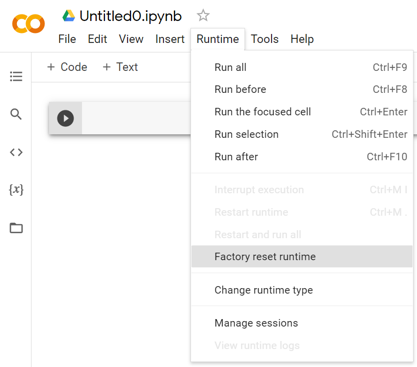

STEP 2.2: SETUP CODE FOR EXCERCISE PART 2

In [13]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import os
import numpy as np
import random
from matplotlib import pyplot as plt

# Define training parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128

# Define network parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 # timesteps
num_classes = 10 # MNIST total classes (0-9 digits)

# Import MNIST dataset from tensorflow_dataset (tfds). More information about tfds can be found on https://www.tensorflow.org/datasets/api_docs/python/tfds
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False, # True
    as_supervised=True,
    with_info=True,
)

# Function to transform train and test datasets
def transform(image, label):
  """Transform images: remove last dimension of size 1"""
  """Transform images: uint8 -> float32"""
  """Transform labels: indices -> one-hots"""
  return tf.cast(tf.squeeze(image, -1), tf.float32) / 255., tf.one_hot(label, 10)

# Pre-process train dataset
ds_train = ds_train.map(
    transform, num_parallel_calls=tf.data.AUTOTUNE) 
ds_train = ds_train.cache() # 
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# Pre-process test dataset
ds_test = ds_test.map(
    transform, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128, drop_remainder=True)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

STEP 2.3: COMPLETE CODE USED TO BUILD LSTM MODELS

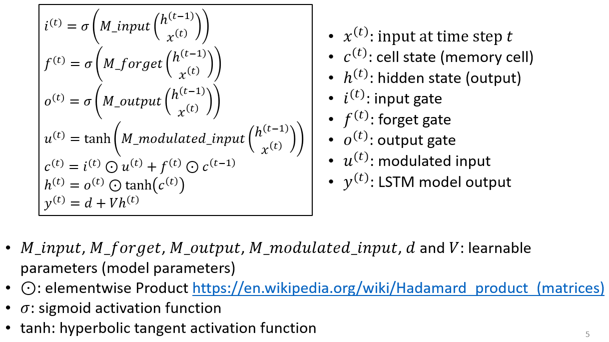

Fig. 2: Formulas for a LSTM model

In [14]:
class Long_short_term_memory(keras.layers.Layer):
  def __init__(self, input_dim, hidden_dim, output_dim, batch_sz):
    super(Long_short_term_memory, self).__init__()
    init = tf.random_normal_initializer()

    self.M_input = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,hidden_dim+input_dim), dtype="float32"),
        trainable=True)
    self.M_forget = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,hidden_dim+input_dim), dtype="float32"),
        trainable=True)
    self.M_output = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,hidden_dim+input_dim), dtype="float32"),
        trainable=True)
    self.M_modulated_input = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,hidden_dim+input_dim), dtype="float32"),
        trainable=True)

    self.d = tf.Variable(
        initial_value=init(shape=(1,output_dim,1), dtype="float32"),
        trainable=True)
    self.V = tf.Variable(
        initial_value=init(shape=(1,output_dim,hidden_dim), dtype="float32"),
        trainable=True)
    
  def call(self, x, h_init, c_init, num_timestep):
    # Inputs:                                                                      
    # x: [batch_sz,num_row,num_column]                                           
    # h_init: [1,num_hidden,1]                                                    
    # c_init: [1,num_hidden,1]                                                   
    # num_timestep: int                                                          
    # Output:                                                                      
    # y: [batch_sz,num_class], softmax normalized class probabilities             

    h = h_init # [b,h,1]
    c = c_init # [b,h,1]
    for ts in range(num_timestep):
      # curr_x: input sequence at the current timestep
      curr_x = tf.expand_dims(x[:,ts,:], -1) # [b,28,1]
      curr_hx = tf.concat((h,curr_x), 1) # [b,h+28,1]

      i = tf.linalg.matmul(self.M_input, curr_hx)
      f = tf.linalg.matmul(self.M_forget, curr_hx)
      o = tf.linalg.matmul(self.M_output, curr_hx)
      ################################################################################
      # TODO:                                                                        #        
      # The code to compute input_gate i, forget_gate f, and output_date o is        #    
      # provided. Complete the space indicated by ***** to compute modulated input u #
      # before sigmoid activation, as shown in the 4th equation in Fig. 2.           #
      # You should use tf.linalg.matmul. More information on tf.linalg.matmul can be #
      # found at https://www.tensorflow.org/api_docs/python/tf/linalg/matmul         #
      ################################################################################
      u = tf.linalg.matmul(self.M_modulated_input, curr_hx)
      ################################################################################
      #                              END OF YOUR CODE                                #
      ################################################################################
      i = tf.math.sigmoid(i)
      f = tf.math.sigmoid(f)
      o = tf.math.sigmoid(o) 
      u = tf.math.tanh(u)

      c = i * u + f * c  
      h = o * tf.math.tanh(c)

    y = self.d + tf.linalg.matmul(self.V, h)
    y =  tf.squeeze(y)
    y = tf.nn.softmax(y, axis=-1) # Convert to probabilities

    return y

STEP 2.4: CONFIGURE THE LSTM MODEL

Use the provided code to configure the LSTM model whose hidden states have the size of 128.

In [15]:
# Configure the LSTM model
LSTM = Long_short_term_memory(input_dim=num_input, 
    hidden_dim=128, 
    output_dim=num_classes, 
    batch_sz=batch_size)

# Instantiate a tf.keras.Model for the LSTM model
# More information can be found at https://www.tensorflow.org/api_docs/python/tf/keras/Model
input_data = tf.keras.Input(shape=(timesteps, num_input), batch_size=batch_size, 
    dtype=tf.float32)
h_init = tf.zeros([batch_size,128,1], tf.float32)
c_init = tf.zeros([batch_size,128,1], tf.float32)
prediction_LSTM = LSTM(input_data, h_init=h_init, c_init=c_init, num_timestep=timesteps)

model_LSTM = tf.keras.Model(input_data, prediction_LSTM)
model_LSTM.compile(optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

STEP 2.5: TRAIN THE LSTM MODEL

You should expect to see training accuracy > 90%.

In [16]:
with tf.device('/GPU:0'):
  model_LSTM.fit(ds_train, epochs=4)

Epoch 1/4
468/468 [==============================] - 34s 18ms/step - loss: 0.6605 - accuracy: 0.7846
Epoch 2/4
468/468 [==============================] - 9s 18ms/step - loss: 0.2139 - accuracy: 0.9361
Epoch 3/4
468/468 [==============================] - 9s 18ms/step - loss: 0.1459 - accuracy: 0.9563
Epoch 4/4
468/468 [==============================] - 9s 18ms/step - loss: 0.1096 - accuracy: 0.9669


STEP 2.6: TEST THE TRAINED LSTM MODEL

You should expect to see testing accuracy > 90%.

In [17]:
# Test the trained LSTM model 
h_init = tf.zeros([batch_size,128,1], tf.float32)
c_init = tf.zeros([batch_size,128,1], tf.float32)

predicted_digits = []
gt_digits = []
for input_sequences, gt_digit in ds_test:
  predicted_digit = LSTM(input_sequences, h_init=h_init, c_init=c_init, num_timestep=timesteps)
  
  # one-hot to index
  predicted_digits.append(np.squeeze(tf.argmax(predicted_digit, axis=-1).numpy()))
  gt_digits.append(np.squeeze(tf.argmax(gt_digit, axis=-1).numpy()))

predicted_digits = np.squeeze(np.concatenate(predicted_digits))
gt_digits = np.squeeze(np.concatenate(gt_digits))

test_accuracy = np.sum(predicted_digits == gt_digits) / np.shape(predicted_digits)[0]

print('Testing accuracy of the LSTM model: %f' % test_accuracy)

Testing accuracy of the LSTM model: 0.970453


STEP 2.7: VISUALIZE TEST RESULT 

Use the provided code to show the LSTM model prediction of a randomly sampled test image. You can run the code in this step a couple more times to test more images.

Ground-truth digit 1. Predicted digit 1 (LSTM)


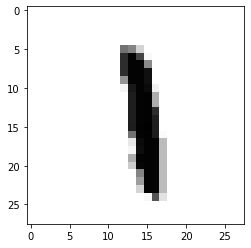

In [18]:
# Randomly select a test image
ds_test_list = list(ds_test)

test_indx = (random.randrange(0, len(ds_test_list)-1), random.randrange(0, batch_size-1))
test_batch = ds_test_list[test_indx[0]]
test_input = test_batch[0][test_indx[1],:] # Test image
test_gt = test_batch[1][test_indx[1],:] # Ground-truth class probabilities

# Use the trained LSTM model to obtain probabilities for each digit (0-9)
LSTM_pred = LSTM(tf.expand_dims(test_input, axis=0), 
    h_init=tf.zeros([1,128,1], tf.float32), 
    c_init=tf.zeros([1,128,1], tf.float32), 
    num_timestep=timesteps) # numpy array

# Plot LSTM prediction 
gt_digit = np.argmax(np.squeeze(test_gt.numpy()))
pred_digit_LSTM = np.argmax(np.squeeze(LSTM_pred))

plt.imshow(test_input.numpy(), cmap=plt.get_cmap('Greys'))
print('Ground-truth digit %d. Predicted digit %d (LSTM)' % (gt_digit, pred_digit_LSTM))
plt.show()

STEP 2.8: ANSWER THE QUESTIONS BELOW

2.8.1: As can be seen, basic RNN and LSTM models with the same hidden state size (128) achieve similar test accuracies at classifying MNIST handwritten digits. In what kind of scenario will LSTM significantly outperform basic RNN? Why is this the case? 

Your Answer: LSTM is best used for image with large dimension. LSTM resolves the vanishing gradient problem that plagues RNNs and it is able to remember information over long periods. The hidden state size is too small for us to see a large difference in test accuracies.

2.8.2: How many trainable parameters are there in the LSTM model?

Hint: You may want to utilize the summary method, as in step 1.9.2.

Compared with the 1st basic RNN model with hidden states of the same size (128), there should be more trainable parameters in the LSTM model.

In [19]:
# If needed, you can complete and run the code below. Space to be completed is indicated by *****.

################################################################################
#                             START OF YOUR CODE                               #        
################################################################################
model_LSTM.summary()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(128, 28, 28)]           0         
                                                                 
 long_short_term_memory (Lon  (128, 10)                81162     
 g_short_term_memory)                                            
                                                                 
Total params: 81,162
Trainable params: 81,162
Non-trainable params: 0
_________________________________________________________________


Your Answer: 81162

# Excercise Part 3: Column Basic RNN

Just like in Excercise Part 1, you will also use a basic RNN model to classify MNIST handwritten digits. **However, instead of using rows of image as input at respective time steps, you will use columns of image, as shown in the figure (b) below.** This means, at the first time step, we input the first column of the image to the network, and at the second step, we input the second column... We call this model column basic RNN model. Can it achieve a similar testing accuracy? Follow the steps below to find out.

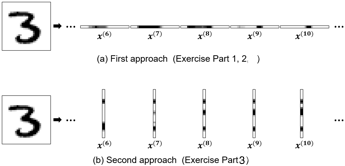

3.1: Reset runtime.

3.2: Run the provided setup code. 

3.3: Copy the completed code from step 1.2. **This step will not work if code in step 1.2 has not been completed correctly.** Modify the lines as instructed below and run.

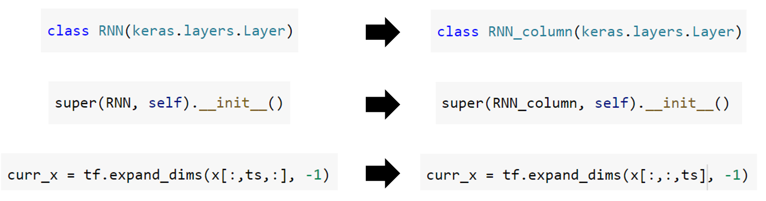

3.4: Run the provided code to configure the column basic RNN model. The size of hidden states is set to 128.

3.5: Run the provided code to train the column basic RNN model. 

3.6: Run the provided code to test the trained column basic RNN model

3.7: Answer questions in 3.7.1. **The answers in 3.7.1 will be graded**.

STEP 3.1: RESET RUNTIME

Variables and functions of Excercise Part 2 are still saved in virtual machines. 

It is a good practice to clear no longer needed past variables and functions in Colab notebook by resetting runtime such that virtual machines can return to original state.。

To do so, select "Factory reset runtime" from "Runtime" drop down menu, as shown below.

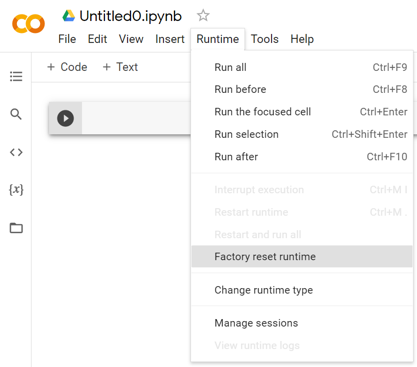

STEP 3.2: SETUP CODE FOR EXCERCISE PART 3

In [20]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import os
import numpy as np
import random
from matplotlib import pyplot as plt

# Define training parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128

# Define network parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 # timesteps
num_classes = 10 # MNIST total classes (0-9 digits)

# Import MNIST dataset from tensorflow_dataset (tfds). More information about tfds can be found on https://www.tensorflow.org/datasets/api_docs/python/tfds
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=False, # True
    as_supervised=True,
    with_info=True,
)

# Function to transform train and test datasets
def transform(image, label):
  """Transform images: remove last dimension of size 1"""
  """Transform images: uint8 -> float32"""
  """Transform labels: indices -> one-hots"""
  return tf.cast(tf.squeeze(image, -1), tf.float32) / 255., tf.one_hot(label, 10)

# Pre-process train dataset
ds_train = ds_train.map(
    transform, num_parallel_calls=tf.data.AUTOTUNE) 
ds_train = ds_train.cache() # 
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# Pre-process test dataset
ds_test = ds_test.map(
    transform, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128, drop_remainder=True)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

STEP 3.3: COPY AND MODIFY TO OBTAIN CODE USED TO BUILD COLUMN BASIC RNN MODELS

Copy the completed code in step 1.2. Below are the lines to modify.

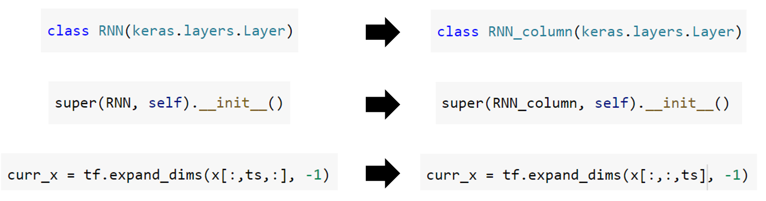

It is worth noting that the formulas are the same for Excercise Part 1 and 3. But here input at each time step is different (column versus row).

In [21]:
################################################################################
#                            START OF YOUR CODE                                #
################################################################################
class RNN_column(keras.layers.Layer):
  def __init__(self, input_dim, hidden_dim, output_dim, batch_sz):
    super(RNN_column, self).__init__()
    init = tf.random_normal_initializer()

    self.b = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,1), dtype="float32"),
        trainable=True)

    self.W = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,hidden_dim), dtype="float32"),
        trainable=True)
    
    self.d = tf.Variable(
        initial_value=init(shape=(1,output_dim,1), dtype="float32"),
        trainable=True)

    self.V = tf.Variable(
        initial_value=init(shape=(1,output_dim,hidden_dim), dtype="float32"),
        trainable=True)
    
    ################################################################################
    # TODO:                                                                        #
    # b, W, U, d, and V are model parameters.                                      #
    # The code to initialize b, W, d, and V is provided above.                     # 
    # Please fill in the space indicated by ***** to initialize U as well.         #
    # Hint: You can infer the shape of U from the 1st equation in Fig. 1.          # 
    ################################################################################
    self.U = tf.Variable(
        initial_value=init(shape=(1,hidden_dim,input_dim), dtype="float32"),
        trainable=True)
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    
  def call(self, x, h_init, num_timestep):
    # Inputs:                                                                      
    # x: [batch_sz,num_row,num_column]                                           
    # h_init: [1,num_hidden,1]                                                                                                       
    # num_timestep: int                                                          
    # Output:                                                                      
    # y: [batch_sz,num_class], softmax normalized class probabilities 

    h = h_init
    for ts in range(num_timestep):
      # curr_x: input sequence at the current timestep
      curr_x = tf.expand_dims(x[:,:,ts], -1) # [b,1,input_dim]
      a = self.b + tf.linalg.matmul(self.W, h) + tf.linalg.matmul(self.U, curr_x) 
      ################################################################################
      # TODO:                                                                        #
      # Fill in the space indicated by ***** to implement the 2nd equation in Fig. 1 #
      # to compute hidden state h from activation a.                                 #
      # You should use tf.math.tanh. More information on tf.math.tanh can be found   #
      # at https://www.tensorflow.org/api_docs/python/tf/math/tanh                   #
      ################################################################################
      h = tf.math.tanh(a)
      ################################################################################
      #                              END OF YOUR CODE                                #
      ################################################################################

    y = self.d + tf.linalg.matmul(self.V, h)
    y =  tf.squeeze(y)
    y = tf.nn.softmax(y, axis=-1)

    return y
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

STEP 3.4: CONFIGURE THE COLUMN BASIC RNN MODEL

Use the provided code to configure the column basic RNN model whose hidden states have the size of 128.

In [22]:
# Configure the column basic RNN model
basic_RNN_column = RNN_column(input_dim=num_input, 
    hidden_dim=128, 
    output_dim=num_classes, 
    batch_sz=batch_size)

# Instantiate a tf.keras.Model for the column basic RNN model
# More information can be found at https://www.tensorflow.org/api_docs/python/tf/keras/Model
input_data = tf.keras.Input(shape=(timesteps, num_input), batch_size=batch_size, 
    dtype=tf.float32)
h_init = tf.zeros([1,128,1], tf.float32)
prediction_basic_RNN_column = basic_RNN_column(input_data, h_init=h_init, num_timestep=timesteps)

model_basic_RNN_column = tf.keras.Model(input_data, prediction_basic_RNN_column)
model_basic_RNN_column.compile(optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

STEP 3.5: TRAIN THE COLUMN BASIC RNN MODEL

You should expect to see training accuracy > 90%.

In [23]:
with tf.device('/GPU:0'):
  model_basic_RNN_column.fit(ds_train, epochs=4)

Epoch 1/4
468/468 [==============================] - 27s 14ms/step - loss: 0.9699 - accuracy: 0.6814
Epoch 2/4
468/468 [==============================] - 4s 8ms/step - loss: 0.4479 - accuracy: 0.8665
Epoch 3/4
468/468 [==============================] - 4s 8ms/step - loss: 0.3191 - accuracy: 0.9055
Epoch 4/4
468/468 [==============================] - 4s 8ms/step - loss: 0.2604 - accuracy: 0.9235


STEP 3.6: TEST THE TRAINED COLUMN BASIC RNN MODEL

You should expect to see testing accuracy > or near 90%.

In [24]:
# Test trained column basic RNN model 
h_init = tf.zeros([1,128,1], tf.float32)

predicted_digits = []
gt_digits = []
for input_sequences, gt_digit in ds_test:
  predicted_digit = basic_RNN_column(input_sequences, h_init=h_init, num_timestep=timesteps)
  
  # one-hot to index
  predicted_digits.append(np.squeeze(tf.argmax(predicted_digit, axis=-1).numpy()))
  gt_digits.append(np.squeeze(tf.argmax(gt_digit, axis=-1).numpy()))

predicted_digits = np.squeeze(np.concatenate(predicted_digits))
gt_digits = np.squeeze(np.concatenate(gt_digits))

test_accuracy = np.sum(predicted_digits == gt_digits) / np.shape(predicted_digits)[0]

print('Testing accuracy of the column basic RNN model: %f' % test_accuracy)

Testing accuracy of the column basic RNN model: 0.934395


STEP 3.7: ANSWER THE QUESTION BELOW

3.7.1: Report testing accuracy of the column basic RNN model. Should it be close to that of the 1st basic RNN model in Excercise Part 1 and why?

Your Answer: 0.934395. Yes, it should be close, the row is swapped with its column, with no alteration to the values, so the test accuracy should be similar.

**Reference: https://github.com/aymericdamien/TensorFlow-Examples/**